# IMPORT MODULES & FUNCTIONS

In [1]:
#IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
import calendar
import seaborn as sns; sns.set()
import itertools
#import datetime
from time import gmtime, strftime
from matplotlib import cm
from IPython.display import display
#%matplotlib qt
#%matplotlib inline

#SET GLOBAL PARAMETERS
# ================== Global parameters for fonts & sizes =================
FONT_SIZE = 20
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': FONT_SIZE, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

from solarcurtailment.energy_calculation import *
from solarcurtailment.clear_sky_day import *
from solarcurtailment.tripping_curt import *
from solarcurtailment.vvar_curt import *
from solarcurtailment.vwatt_curt import *
from solarcurtailment.polyfit import *
from solarcurtailment.file_processing import *
from solarcurtailment.data_visualization import *

#class instantiation
file_processing = FileProcessing()
clear_sky_day = ClearSkyDay()
data_visualization = DataVisualization()
energy_calculation = EnergyCalculation()
tripping_curt = TrippingCurt()
polyfit_f = Polyfit()
vvar_curt = VVarCurt()
vwatt_curt = VWattCurt()

#from FileProcessing 
def input_monthly_files(file_path, data_date_idx):
    """Open time-series D-PV data and ghi data of a certain month. Only compatible for SoLA data format.

    Args:
        file_path (str): The file location of the data
        data_date_idx (str): The month of the files in format 'YYYYMM' eg '201907'

    Returns:
        data (df): the opened & cleaned time-series D-PV data
        ghi (df): the opened & cleaned ghi data
        data_ori (df): the opened & unmodified time-series D-PV data
        ghi_ori (df): the opened & unmodified ghi data
    """
    
    data_path = file_path + r"/processed_unsw_" + data_date_idx + '_data_raw.csv'
    data_ori = pd.read_csv(data_path)
    data = data_ori.set_index('utc_tstamp')

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"/sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 
    ghi_ori = ghi.copy()

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    
    return data, ghi, data_ori, ghi_ori

C:\Users\samha\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# CHECK ALL CLEAR SKY DAYS DATE
Find list of all dates which are clear sky days (csd). This result is obtained from Tim's script

In [2]:
csd_201909 = ['2019-09-12', '2019-09-17', '2019-09-18', '2019-09-26', '2019-09-29', '2019-09-30']
csd_201910 = ['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-29']
csd_201911 = ['2019-11-18', '2019-11-27']
csd_201912 = ['2019-12-16', '2019-12-19', '2019-12-25', '2019-12-28']
csd_202001 = ['2020-01-01', '2020-01-02', '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-17', '2020-01-29', '2020-01-30']
csd_202002 = ['2020-02-04', '2020-02-05', '2020-02-06', '2020-02-10', '2020-02-11', '2020-02-13', '2020-02-22', '2020-02-23']
csd_202003 = ['2020-03-03', '2020-03-08', '2020-03-10', '2020-03-14', '2020-03-15', '2020-03-25', '2020-03-26']
csd_202004 = ['2020-04-08', '2020-04-09', '2020-04-13', '2020-04-24']

csd_list = csd_201909 + csd_201910 + csd_201911 + csd_201912 + csd_202001 + csd_202002 + csd_202003 + csd_202004

# INPUT ALL MONTHLY DATA & GENERAL FILES

In [3]:
#file_path = r"/Users/samhan/Downloads/data" #for running in Samhan's laptop
file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer

month_list = ['201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004']
data = {}
data_ori = {}
ghi = {}
ghi_ori = {}
for month in month_list:
    print('processing {} ...'.format(month))
    data[month], ghi[month], data_ori[month], ghi_ori[month] = input_monthly_files(file_path, month)
    data[month]['date'] = data[month].index.date
    
site_details, unique_cids= file_processing.input_general_files(file_path)

processing 201909 ...
processing 201910 ...
processing 201911 ...
processing 201912 ...
processing 202001 ...
processing 202002 ...
processing 202003 ...
processing 202004 ...


# LOOP OVER ALL SITES

In [47]:
summary = pd.DataFrame()

for c_id in unique_cids['c_id']: #for the whole data testing
#for c_id in unique_cids['c_id'][:3]: #for testing
    last_month_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in csd_list: #for the whole data testing
    #for date in csd_list[:3]: #for testing
        print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]

        #check tripping curtailment
        size_is_ok = file_processing.check_data_size(data_analyzed)
        if not size_is_ok:
            print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
        else:
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            data_site, polyfit, is_good_polyfit_quality = polyfit_f.check_polyfit(data_site, ac_cap)
            is_clear_sky_day = True #because the date is already chosen which is a clear sky day
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(csd_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

Analyzing c_id 1489730840 date 2019-09-12 ...
Analyzing c_id 1489730840 date 2019-09-17 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2019-09-18 ...
Analyzing c_id 1489730840 date 2019-09-26 ...
Analyzing c_id 1489730840 date 2019-09-29 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2019-09-30 ...
Analyzing c_id 1489730840 date 2019-10-01 ...
Cannot analyze 1489730840 site on 2019-10-01 due to incomplete data.
Analyzing c_id 1489730840 date 2019-10-02 ...
Analyzing c_id 1489730840 date 2019-10-03 ...
Analyzing c_id 1489730840 date 2019-10-29 ...
Analyzing c_id 1489730840 date 2019-11-18 ...
Analyzing c_id 1489730840 date 2019-11-27 ...
Analyzing c_id 1489730840 date 2019-12-16 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2019-12-19 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2019-12-25 ...
Analyzing c_id 1489730840 date 2019-12-28 ...
Analyzing c_id 1489730840 date 2020-01-01 ...
Cannot analyze 1489730840 site on 2020-01-01 due to incomplete data.
Analyzing c_id 1489730840 date 2020-01-02 ...
Analyzing c_id 1489730840 date 2020-01-06 ...
Analyzing c_id 1489730840 date 2020-01-07 ...
Analyzing c_id 1489730840 date 2020-01-08 ...
Analyzing c_id 1489730840 date 2020-01-12 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-01-13 ...
Analyzing c_id 1489730840 date 2020-01-14 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-01-17 ...
Analyzing c_id 1489730840 date 2020-01-29 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-01-30 ...
Analyzing c_id 1489730840 date 2020-02-04 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-02-05 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-02-06 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-02-10 ...
Analyzing c_id 1489730840 date 2020-02-11 ...
Analyzing c_id 1489730840 date 2020-02-13 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-02-22 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-02-23 ...
Analyzing c_id 1489730840 date 2020-03-03 ...
Analyzing c_id 1489730840 date 2020-03-08 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-03-10 ...
Analyzing c_id 1489730840 date 2020-03-14 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-03-15 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-03-25 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-03-26 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

Analyzing c_id 1489730840 date 2020-04-08 ...
Analyzing c_id 1489730840 date 2020-04-09 ...
Analyzing c_id 1489730840 date 2020-04-13 ...
Analyzing c_id 1489730840 date 2020-04-24 ...


C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['non_clear_sky_day_flag'] = 0
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
C:\Users\samha\anaconda3\lib\site-packages\solarcurtailment\tripping_curt.py:690: SettingWithCopyWarning: 
A value is trying to be set o

# SUMMARY PROCESSING

In [48]:
summary['percentage_of_generation_lost'] = summary['total_tripping_curtailment (kWh)'] / summary['total_energy_generation (kWh)'] * 100
summary['proportion of days with curtailment'] = summary['count curtailment (days)'] / summary['total days (days)'] * 100
summary.sort_values(by = 'percentage_of_generation_lost', ascending = False, inplace = True)
summary.reset_index(drop = True, inplace = True)
summary['proportion_of_sites'] = summary.index/(len(summary)-1) * 100

In [19]:
summary.to_csv(file_path + r'/tripping_csd_summary.csv', index = False) 

# VISUALIZATION SIMILAR TO FIGURE 14

In [96]:
summary = summary_all_sites.copy()

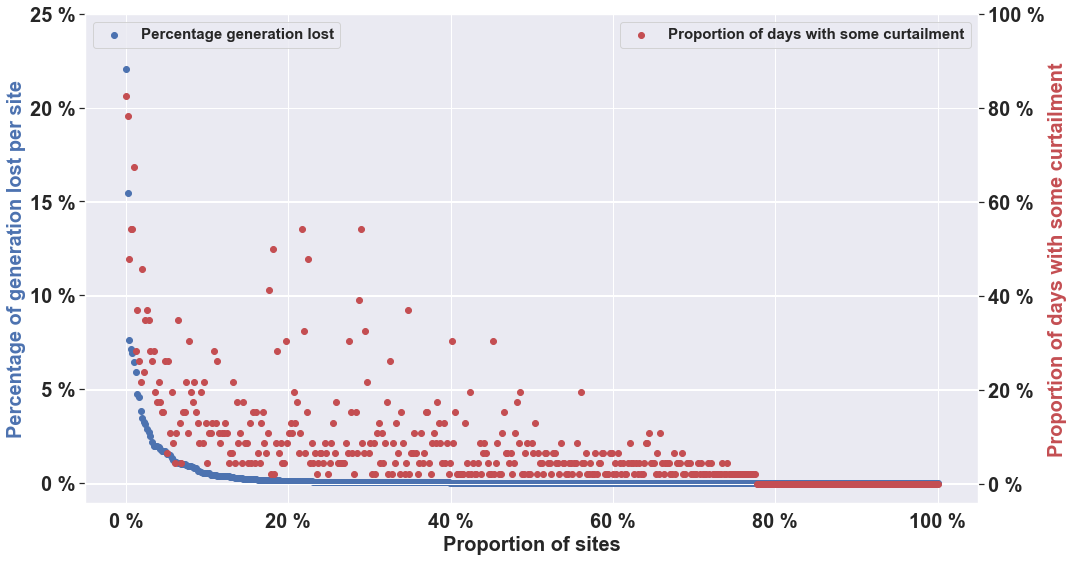

In [98]:
fig, ax1 = plt.subplots()
fig.set_size_inches(16, 9)

ax1.scatter(summary['proportion_of_sites'], summary["percentage_of_generation_lost"], color = 'b', 
            label = 'Percentage generation lost')

ax1.set_xlabel('Proportion of sites', **fontdict)
ax1.set_ylabel('Percentage of generation lost per site', **fontdict, color='b')

ax1.set_xticks([0, 20, 40, 60, 80, 100])
ax1.set_xticklabels(['0 %', '20 %', '40 %', '60 %', '80 %', '100 %'], **fontdict)
ax1.set_yticks([0, 5, 10, 15, 20, 25])
ax1.set_yticklabels(['0 %', '5 %', '10 %', '15 %', '20 %', '25 %'], **fontdict)
ax1.legend(loc = 2, prop={'size': 15})

ax2 = ax1.twinx()
ax2.scatter(summary['proportion_of_sites'], summary['proportion of days with curtailment'], color='r',
           label = 'Proportion of days with some curtailment')
ax2.set_ylabel('Proportion of days with some curtailment', color='r', **fontdict)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticklabels(['0 %', '20 %', '40 %', '60 %', '80 %', '100 %'], **fontdict)
ax2.legend(loc = 1, prop={'size': 15})

plt.show()

# UPDATING SPREADSHEET

In [100]:
spreadsheet_before = pd.read_excel(file_path + r'/SolA Curtailment Summary_Final.xlsx')
spreadsheet_before.drop(columns = 'Unnamed: 0', inplace = True)

new_data = summary_all_sites[['c_id', 'total_energy_generation (kWh)', 'total_tripping_curtailment (kWh)']].copy()
new_data.rename(columns={
    "total_energy_generation (kWh)": "total_energy_generation_csd (kWh)",
    "total_tripping_curtailment (kWh)": "total_tripping_curtailment_csd (kWh)"}, inplace = True)

spreadsheet_after = pd.merge(spreadsheet_before, new_data, left_on = 'c_id', right_on = 'c_id', how = 'inner')

In [117]:
spreadsheet_after

,site_id,c_id,total_generation_kWh_all_days_Tim,total_generation_kWh_Naomi_calc,total_generation_kWh_Baran,total_generation_kWh_clear_sky_days,total_tripping_curtailment_kWh,total_v_var_curtailment_kWh_Tim,total_v_var_curtailment_kWh_Baran,total_v_watt_Curtailment_kWh,...,v_var_lower,v_watt_upper,v_watt_lower,TOTAL_UPPER,TOTAL_LOWER,Tripping,V-Watt,V-Var,total_energy_generation_csd (kWh),total_tripping_curtailment_csd (kWh)
0,962508189,1317822057,5719.944363,1757.258517,5510.221649,NaN,339.588285,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,19.324891,6.162879,19.324891,0.00000,0.000000,1157.899115,178.695484
1,1768287280,939510347,6122.345767,1849.047081,5943.591770,NaN,151.017746,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,8.167328,2.540850,8.167328,0.00000,0.000000,1180.380074,90.085169
2,878597128,298243910,5748.966417,1389.962099,5665.764965,NaN,102.374650,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,7.365284,1.806899,7.365284,0.00000,0.000000,1158.847052,68.395234
3,1081062438,441066515,5882.510095,1667.429607,5647.239523,NaN,115.114249,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,6.903695,2.038416,6.903695,0.00000,0.000000,1210.260190,77.987289
4,454204467,1926768907,5620.132018,1417.460100,5412.858641,NaN,97.676155,0.000000,33.749897,0.00,...,0.000000,0.00000,0.000000,7.514441,1.804521,6.890928,0.00000,0.623513,1118.214170,51.142208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2038592245,432573265,7091.242991,2263.771494,6907.557872,NaN,0.091405,0.000000,0.255956,0.00,...,0.000000,0.00000,0.000000,0.007743,0.001323,0.004038,0.00000,0.003705,1367.316347,0.000000
495,248990444,362267093,5813.941242,476.882447,5619.366217,NaN,0.018261,0.000000,0.003961,0.00,...,0.000000,0.00000,0.000000,0.003900,0.000325,0.003829,0.00000,0.000070,1159.868896,0.000000
496,1736222971,1836936064,7403.503012,2301.958848,7120.210089,NaN,0.075059,0.000000,1.612969,0.00,...,0.000000,0.00000,0.000000,0.025914,0.001054,0.003261,0.00000,0.022653,1429.256315,0.000000
497,1836477388,499746036,4062.871639,194.722231,4017.525521,NaN,0.005558,0.000000,5.619840,0.00,...,0.000000,0.00000,0.000000,0.142737,0.000138,0.002854,0.00000,0.139883,835.831255,0.000273


In [121]:
spreadsheet_after.to_excel(file_path + r'/SolA Curtailment Summary_Final_tripping.xlsx', index = False) 

# ANALYZE A SITE FOR A CERTAIN DAY

Just for testing purpose. It is not used in the actual script deployment

In [8]:
# c_id = 1967552706
c_id = 1758802400
date = '2020-04-09'

In [9]:
print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
#filter D-PV time series data
date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
month_analyzed = date[:4] + date [5:7]

date_filter = data[month_analyzed].date == date_dt
site_id_filter = data[month_analyzed]['c_id'] == c_id
data_analyzed = data[month_analyzed].loc[date_filter & site_id_filter]

#check tripping curtailment
size_is_ok = file_processing.check_data_size(data_analyzed)
if not size_is_ok:
    print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
else:
    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
    data_site = file_processing.resample_in_minute(data_site)
    data_site, polyfit, is_good_polyfit_quality = polyfit_f.check_polyfit(data_site, ac_cap)
    is_clear_sky_day = True #because the date is already chosen which is a clear sky day
    tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
    energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)

Analyzing c_id 1758802400 date 2020-04-09 ...


# COMBINE ALL RESULTS

This is to combine some of the results in the previous section that is done in seperate times. Should not be needed if the above section is run only once for all sites. 

In [22]:
summary_1 = pd.read_csv(file_path + r'/tripping_csd_summary.csv')
summary_2 = pd.read_csv(file_path + r'/tripping_csd_summary_2.csv')
summary_3 = pd.read_csv(file_path + r'/tripping_csd_summary_3.csv')
summary_4 = pd.read_csv(file_path + r'/tripping_csd_summary_4.csv')
summary_5 = pd.read_csv(file_path + r'/tripping_csd_summary_5.csv')

In [37]:
summary_all_sites = pd.concat([summary_1, summary_2, summary_3, summary_4, summary_5])

In [93]:
summary_all_sites.sort_values(by = 'percentage_of_generation_lost', ascending = False, inplace = True)
summary_all_sites.reset_index(drop = True, inplace = True)
summary_all_sites['proportion_of_sites'] = summary_all_sites.index/(len(summary_all_sites)-1) * 100

In [120]:
summary_all_sites.to_csv(file_path + r'/tripping_csd_summary_all.csv', index = False) 

In [119]:
summary_all_sites

,c_id,total_energy_generation (kWh),total_tripping_curtailment (kWh),count curtailment (days),total days (days),percentage_of_generation_lost,proportion of days with curtailment,proportion_of_sites
0,1732727321,964.424277,212.613161,38,46,22.045604,82.608696,0.000000
1,1317822057,1157.899115,178.695484,36,46,15.432733,78.260870,0.200803
2,939510347,1180.380074,90.085169,22,46,7.631878,47.826087,0.401606
3,2084803628,1181.382575,84.273814,25,46,7.133491,54.347826,0.602410
4,1625233287,1149.328966,79.370201,25,46,6.905786,54.347826,0.803213
...,...,...,...,...,...,...,...,...
494,538085926,508.175240,0.000000,0,46,0.000000,0.000000,99.196787
495,1803391106,974.033866,0.000000,0,46,0.000000,0.000000,99.397590
496,67797136,592.931170,0.000000,0,46,0.000000,0.000000,99.598394
497,302951762,1321.014605,0.000000,0,46,0.000000,0.000000,99.799197


# MESSY BELOW